# The Perceptron

We just employed an optimization method - stochastic gradient descent, without really thinking twice about why it should work at all. It's probably worth while to pause and see whether we can gain some intuition about why this should actually work at all. We start with considering the E. Coli of machine learning algorithms - the Perceptron. After that, we'll give a simple convergence proof for SGD. This chapter is not really needed for practitioners but will help to understand why the algorithms that we use are working at all. 

In [1]:
import mxnet as mx
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np
mx.random.seed(1)

## A Separable Classification Problem

The Perceptron algorithm aims to solve the following problem: given some classification problem of data $x \in \mathbb{R}^d$ and labels $y \in \{\pm 1\}$, can we find a linear function $f(x) = w^\top x + b$ such that $f(x) > 0$ whenever $y = 1$ and $f(x) < 0$ for $y = -1$. Obviously not all classification problems fall into this category but it's a very good baseline for what can be solved easily. It's also the kind of problems computers could solve in the 1960s. The easiest way to ensure that we have such a problem is to fake it by generating such data. We are going to make the problem a bit more interesting by specifying how well the data is separated. 

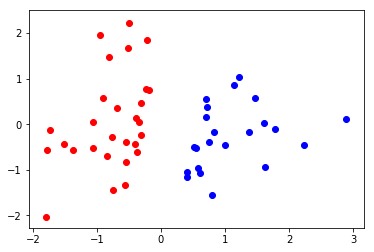

In [2]:
# generate fake data that is linearly separable with a margin epsilon given the data
def getfake(samples, dimensions, epsilon):
    wfake = nd.random_normal(shape=(dimensions))   # fake weight vector for separation
    bfake = nd.random_normal(shape=(1))            # fake bias
    wfake = wfake / nd.norm(wfake)                 # rescale to unit length

    # making some linearly separable data, simply by chosing the labels accordingly
    X = nd.zeros(shape=(samples, dimensions))
    Y = nd.zeros(shape=(samples))

    i = 0
    while (i < samples):
        tmp = nd.random_normal(shape=(1,dimensions))
        margin = nd.dot(tmp, wfake) + bfake
        if (nd.norm(tmp).asscalar() < 3) & (abs(margin.asscalar()) > epsilon):
            X[i,:] = tmp
            Y[i] = 2*(margin > 0) - 1
            i += 1
    return X, Y

# plot the data with colors chosen according to the labels
def plotdata(X,Y):
    for (x,y) in zip(X,Y):
        if (y.asscalar() == 1):
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='r')
        else:
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='b')

# plot contour plots on a [-3,3] x [-3,3] grid 
def plotscore(w,d):
    xgrid = np.arange(-3, 3, 0.02)
    ygrid = np.arange(-3, 3, 0.02)
    xx, yy = np.meshgrid(xgrid, ygrid)
    zz = nd.zeros(shape=(xgrid.size, ygrid.size, 2))
    zz[:,:,0] = nd.array(xx)
    zz[:,:,1] = nd.array(yy)
    vv = nd.dot(zz,w) + b
    CS = plt.contour(xgrid,ygrid,vv.asnumpy())
    plt.clabel(CS, inline=1, fontsize=10)
            
X, Y = getfake(50, 2, 0.3)
plotdata(X,Y)
plt.show()

Now we are going to use the simplest possible algorithm to learn parameters. It's inspired by the [Hebbian Learning Rule](https://en.wikipedia.org/wiki/Hebbian_theory) which suggests that positive events should be reinforced and negative ones diminished. The analysis of the algorithm is due to Rosenblatt and we will give a detailed proof of it after illustrating how it works. In a nutshell, after initializing parameters $w = 0$ and $b = 0$ it updates them by $y x$ and $y$ respectively to ensure that they are properly aligned with the data. Let's see how well it works:

Encountered an error and updated parameters
data   [ 0.57595438 -0.95017916], label -1.0
weight [-0.57595438  0.95017916], bias  -1.0


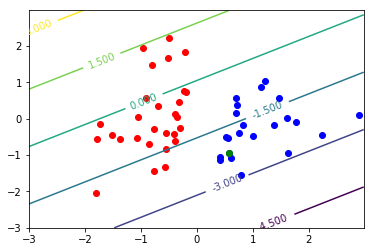

Encountered an error and updated parameters
data   [-0.3469252   0.03751944], label 1.0
weight [-0.92287958  0.98769861], bias  0.0


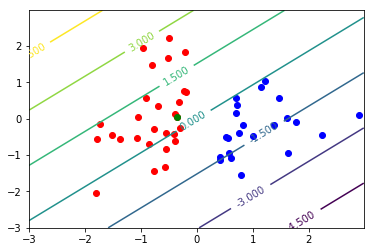

Encountered an error and updated parameters
data   [-1.80471897 -2.04010558], label 1.0
weight [-2.72759867 -1.05240703], bias  1.0


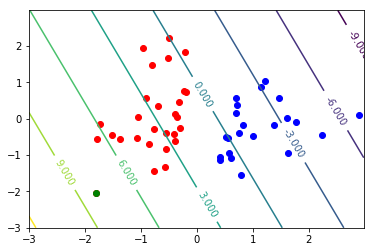

Encountered an error and updated parameters
data   [ 0.60334933 -1.08074296], label -1.0
weight [-3.33094788  0.02833593], bias  0.0


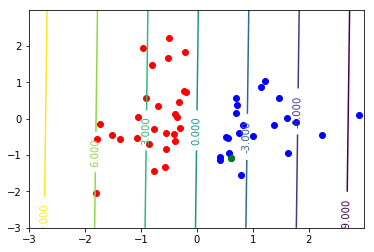

In [4]:
def perceptron(w,b,x,y):
    if (y * (nd.dot(w,x) + b)).asscalar() <= 0:
        w += y * x
        b += y
        return 1
    else:
        return 0

w = nd.zeros(shape=(2))
b = nd.zeros(shape=(1))
for (x,y) in zip(X,Y):
    res = perceptron(w,b,x,y)
    if (res == 1):
        print('Encountered an error and updated parameters')
        print('data   {}, label {}'.format(x.asnumpy(),y.asscalar()))
        print('weight {}, bias  {}'.format(w.asnumpy(),b.asscalar()))
        plotscore(w,b)
        plotdata(X,Y)
        plt.scatter(x[0].asscalar(), x[1].asscalar(), color='g')
        plt.show()

As we can see, the model has learned something - all the red dots are positive and all the blue dots correspond to a negative value. Moreover, we saw that the values for $w^\top x + b$ became more extreme as values over the grid. Did we just get lucky in terms of classification or is there any math behind it? Obviously there is, and there's actually a nice theorem to go with this. It's the perceptron convergence theorem.

## The Perceptron Convergence Theorem

**Theorem** Given data $x_i$ with $\|x_i\| \leq R$ and labels $y_i \in \{\pm 1\}$ for which there exists some pair of parameters $(w^*, b^*)$ such that $y_i((w^*)^\top x_i + b) \geq \epsilon$ for all data, and for which $\|w^*\| \leq 1$ and $b^2 \leq 1$, then the perceptron algorithm converges after at most $2 (R^2 + 1)/\epsilon^2$ iterations.

The cool thing is that this theorem is *independent of the dimensionality of the data*. Moreover, it is *independent of the number of observations*. Lastly, looking at the algorithm itself, we see that we only need to store the mixtakes that the algorithm made - for the data that was classified correctly no update on $(w,b)$ happened. 
As a first step, let's check how accurate the theorem is.

In [ ]:
Eps = np.arange(0.025, 0.45, 0.025)
Err = np.zeros(shape=(Eps.size))

for j in range(10):
    for (i,epsilon) in enumerate(Eps):
        X, Y = getfake(1000, 2, epsilon)

        for (x,y) in zip(X,Y):
            Err[i] += perceptron(w,b,x,y)

Err = Err / 10.0            
plt.plot(Eps, Err, label='average number of updates for training')
plt.legend()
plt.show()

As we can see, the number of errors (and with it, updates) decreases inverseley with the width of the margin. Let's see whether we can put this into equations. The first thing to consider is the size of the inner product between $(w,b)$ and $(w^*, b^*)$, the parameter that solves the classification problem with margin $\epsilon$. Note that we do not need explicit knowledge of $(w^*, b^*)$ for this, just know about its existence. For convenience, we will index $w$ and $b$ by $t$, the number of updates on the parameters. Moreover, whenever convenient we will treat $(w,b)$ as a new vector with an extra dimension and with the appropriate terms such as norms $\|(w,b)\|$ and inner products. 

First off, $w_0^\top w^* + b_0 b^* = 0$ by construction. Second, by the update rule we have that

$$\begin{eqnarray}
(w_{t+1}, b_{t+1})^\top (w^*, b^*) = & (w_t, b_t)^\top (w^*, b^*) + y_t \left(x_t^\top w^* + b^*\right)\\
\geq & (w_t, b_t)^\top (w^*, b^*) + \epsilon \\
\geq & (t+1) \epsilon
\end{eqnarray}$$

Here the first equality follows from the definition of the weight updates. The next inequality follows from the fact that $(w^*, b^*)$ separate the problem with margin at least $\epsilon$, and the last inequality is simply a consequence of iterating this inequality $t+1$ times. Growing alignment between the 'ideal' and the actual weight vectors is great, but only if the actual weight vectors don't grow too rapidly. So we need a bound on their length:

$$\begin{eqnarray}
\|(w_{t+1}, b_{t+1}\|^2 \geq & \|(w_t, b_t)\|^2 + 2 y_t x_t^\top w_t + 2 y_t b_t + \|(x_t, 1)\|^2 \\
= & \|(w_t, b_t)\|^2 + 2 y_t \left(x_t^\top w_t + b_t\right) + \|(x_t, 1)\|^2 \\
\geq & \|(w_t, b_t)\|^2  + R^2 + 1 \\
\geq & (t+1) (R^2 + 1)
\end{eqnarray}$$

Now let's combine both inequalities. By Cauchy-Schwartz, i.e. $\|a\| \cdot \|b\| \geq a^\top b$ and the first inequality we have that $t \epsilon \leq (w_t, b_t)^\top (w^*, b^*) \leq \|(w_t, b_t)\| \sqrt{2}$. Using the second inequality we furthermore get $\|(w_t, b_t)\| \leq \sqrt{t (R^2 + 1)}$. Combined this yields

$$t \epsilon \leq \sqrt{2 t (R^2 + 1)}$$

This is a strange equation - we have a linear term on the left and a sublinear term on the right. So this inequality clearly cannot hold indefinitely for large $t$. The only logical conclusion is that there must never be updates beyond when the inequality is no longer satisfied. We have $t \leq 2 (R^2 + 1)/\epsilon^2$, which proves our claim. 

**Note** - sometimes the perceptron convergence theorem is written without bias $b$. In this case a lot of things get simplified both in the proof and in the bound, since we can do away with the constant terms. Without going through details, the theorem becomes $t \leq R^2/\epsilon^2$. 

**Note** - the perceptron convergence proof crucially relied on the fact that the data is actually separable. If this is not the case, the perceptron algorithm will diverge. It will simply keep on trying to get things right by updating $(w,b)$. And since it has no safeguard to keep the parameters bounded, the solution will get worse. This sounds like an 'academic' concern, alas it is not. The avatar in the computer game [Black and White](https://en.wikipedia.org/wiki/Black_%26_White_(video_game%29) used the perceptron to adjust the avatar. Due to the poorly implemented update rule the game quickly became unplayable after a few hours (as one of the authors can confirm).

## Stochastic Gradient Descent

The perceptron algorithm also can be viewed as a stochastic gradient descent algorithm, albeit with a rather strange loss function: $\mathrm{max}(0, -y f(x))$. This is commonly called the hinge loss. As can be checked quite easily, its gradient is $0$ whenever $y f(x) > 0$, i.e. whenver $x$ is classified correctly, and gradient $-y$ for incorrect classification. For a linear function, this leads exactly to the updates that we have (with the minor difference that we consider $f(x) = 0$ as an example of incorrect classification). To get some intuition, let's plot the loss function.

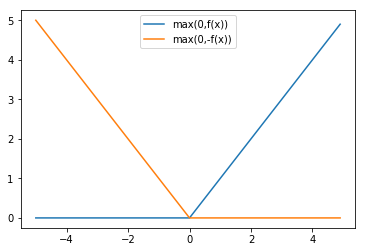

In [5]:
f = np.arange(-5,5,0.1)
zero = np.zeros(shape=(f.size))
lplus = np.max(np.array([f,zero]), axis=0)
lminus = np.max(np.array([-f,zero]), axis=0)
plt.plot(f,lplus, label='max(0,f(x))')
plt.plot(f,lminus, label='max(0,-f(x))')
plt.legend()
plt.show()

More generally, a stochastic gradient descent algorithm uses the following template:
```
initialize w
loop over data and labels (x,y):
     compute f(x)
     compute loss gradient g = partial_w l(y, f(x))
     w = w - eta g
```
Here the learning rate $\eta$ may well change as we iterate over the data. Moreover, we may traverse the data in nonlinear order (e.g. we might reshuffle the data), depending on the specific choices of the algorithm. The issue is that as we go over the data, sometimes the gradient might point us into the right direction and sometimes it might not. Intuitively, on average things *should* get better. But to be really sure, there's only one way to find out - we need to prove it. We pick a simple and elegant (albeit a bit restrictive) proof of [Nesterov and Vial](http://dl.acm.org/citation.cfm?id=1377347). 

The situation we consider are *convex* losses. This is a bit restrictive in the age of deep networks but still quite instructive (in addition to that, nonconvex convergence proofs are a lot messier). For recap - a convex function $f(x)$ satisfies $f(\lambda x + (1-\lambda) x') \leq \lambda f(x) + (1-\lambda) f(x')$, that is, the linear interpolant between function values is *larger* than the function values in between. Likewise, a convex set $S$ is a set where for any points $x, x' \in S$ the line $[x,x']$ is in the set, i.e. $\lambda x + (1-\lambda) x' \in S$ for all $\lambda \in [0,1]$. Now assume that $w^*$ is the minimizer of the expected loss that we are trying to minimize, e.g. 

$$w^* = \mathrm{argmin}_w R(w) \text{ where } R(w) = \frac{1}{m} \sum_{i=1}^m l(y_i, f(x_i, w))$$

Let's assume that we actually *know* that $w^*$ is contained in some set convex set $S$, e.g. a ball of radius $R$ around the origin. This is convenient since we want to make sure that during optimization our parameter $w$ doesn't accidentally diverge. We can ensure that, e.g. by shrinking it back to such a ball whenever needed. 

Secondly, assume that we have an upper bound on the magnitude of the gradient $g_i := \partial_w l(y_i, f(x_i, w))$ for all $i$ by some constant $L$ (it's called so since this is often referred to as the Lipschitz constant). Again, this is super useful since we don't want $w$ to diverge while we're optimizing. In practice, many algorithms employ e.g. *gradient clipping* to force our gradients to be well behaved, by shrinking the gradients back to something tractable.

Third, to get rid of variance in the parameter $w_t$ that is obtained during the optimization, we use the weighted average over the entire optimization process as our solution, i.e. we use $\bar{w} := \sum_t \eta_t w_t / \sum_t \eta_t$. 

Let's look at the distance $r_t := \|w_t - w^*\|$, i.e. the distance between the optimal solution vector $w^*$ and what we currently have. It is bounded as follows:

$$\begin{eqnarray}
\|w_{t+1} - w^*\|^2 = & \|w_t - w^*\|^2 + \eta_t^2 \|g_t\|^2 - 2 \eta_t g_t^\top (w_t - w^*) \\
\leq & \|w_t - w^*\|^2 + \eta_t^2 L^2 - 2 \eta_t g_t^\top (w_t - w^*) 
\end{eqnarray}$$

Next we use convexity of $R(w)$. We know that $R(w^*) \geq R(w_t) + \partial_w R(w_t)^\top (w^* - w_t)$ and moreover that the average of function values is larger than the function value of the average, i.e. $\sum_{t=1}^T \eta_t R(w_t) / \sum_t \eta_t \geq R(\bar{w})$. The first inequality allows us to bound the expected decrease in distance to optimality via

$$\mathbf{E}[r_{t+1} - r_t] \leq \eta_t^2 L^2 - 2 \eta_t \mathbf{E}[g_t^\top (w_t - w^*)] \leq
\eta_t^2 L^2 - 2 \eta_t \mathbf{E}[R[w_t] - R[w^*]]$$

Summing over $t$ and using the facts that $r_T \geq 0$ and that $w$ is contained inside a ball of radius $R$ yields:

$$-R^2 \leq L^2 \sum_{t=1}^T \eta_t^2 - 2 \sum_t \eta_t \mathbf{E}[R[w_t] - R[w^*]]$$

Rearranging terms, using convexity of $R$ the second time, and dividing by $\sum_t \eta_t$ yields a bound on how far we are likely to stray from the best possible solution:

$$\mathbf{E}[R[\bar{w}]] - R[w^*] \leq \frac{R^2 + L^2 \sum_{t=1}^T \eta_t^2}{2\sum_{t=1}^T \eta_t}$$

Depending on how we choose $\eta_t$ we will get different bounds. For instance, if we make $\eta$ constant, i.e. if we use a constant learning rate, we get the bounds $(R^2 + L^2 \eta^2 T)/(2 \eta T)$. This is minimized for $\eta = R/L\sqrt{T}$, yielding a bound of $RL/\sqrt{T}$. A few things are interesting in this context: 

* If we are potentially far away from the optimal solution, we should use a large learning rate (the O(R) dependency).
* If the gradients are potentially large, we should use a smaller learning rate (the O(1/L) dependency). 
* If we have a long time to converge, we should use a smaller learning rate, but not too small. 
* Large gradients and a large degree of uncertainty as to how far we are away from the optimal solution lead to poor convergence. 
* More optimization steps make things better. 

None of these insights are terribly surprising, albeit useful to keep in mind when we use SGD in the wild. And this was the very point of going through this somewhat tedious proof. Furthermore, if we use a decreasing learning rate, e.g. $\eta_t = O(1/\sqrt{t})$, then our bounds are somewhat less tight, and we get a bound of $O(\log T / \sqrt{T})$ bound on how far away from optimality we might be. The key difference is that for the decreasing learning rate we need not know when to stop. In other words, we get an anytime algorithm that provides a good result at any time, albeit not as good as what we could expect if we knew how much time to optimize we have right from the beginning. 
